# **I LOVE PANDAS**

![PANDA](https://media4.giphy.com/media/ue2Mb3oHDmMmc/200w.gif?cid=6c09b952l8sef3qps8u3v1kc880w0kji5luz2we7uaf62y7r&ep=v1_gifs_search&rid=200w.gif&ct=g)    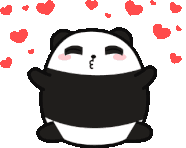       ![DELETE](https://princesselifestyle.files.wordpress.com/2014/11/tumblr_n2t9ubd5td1s36kfoo1_500.gif)





## Intro + EDA

In [96]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load data
fraudie = pd.read_csv("input_data2/financial_transaction_data.csv")

# EDA
print(fraudie.shape)
print(" ")
print(fraudie.head())
print(" ")
print(fraudie.info())
print(" ")
print(fraudie.describe())
print(" ")

# Missing values (nada bubba)
missing_values = fraudie.isnull().sum()
print(missing_values)
print(" ")




## Outliers

/Users/avinashgadde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


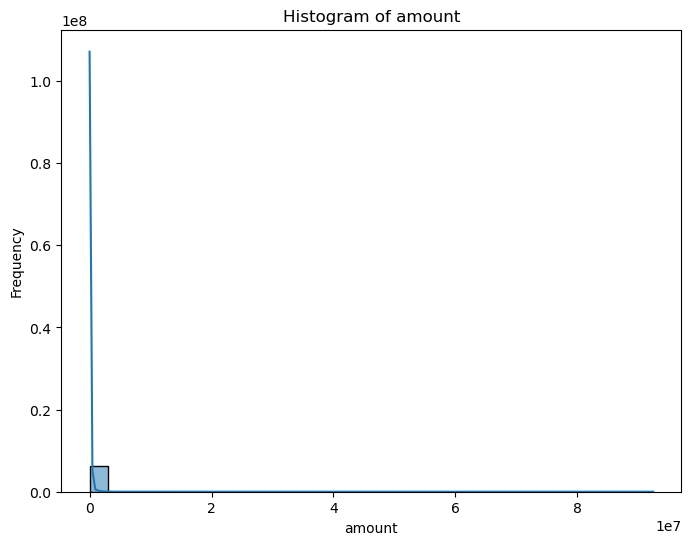

/Users/avinashgadde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


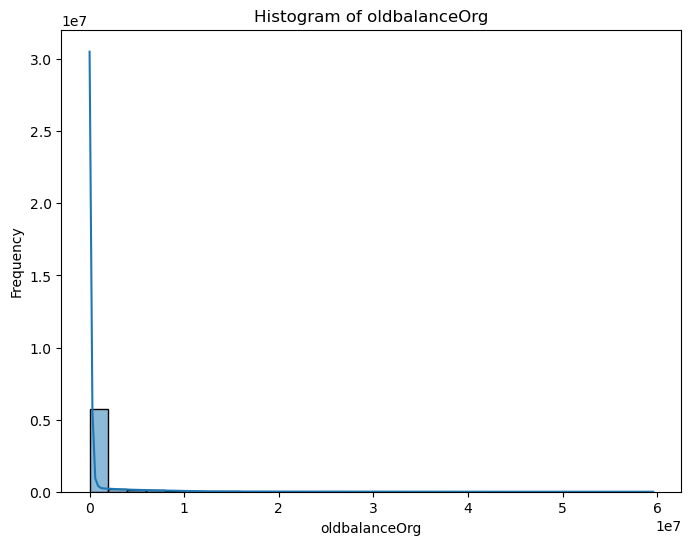

/Users/avinashgadde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


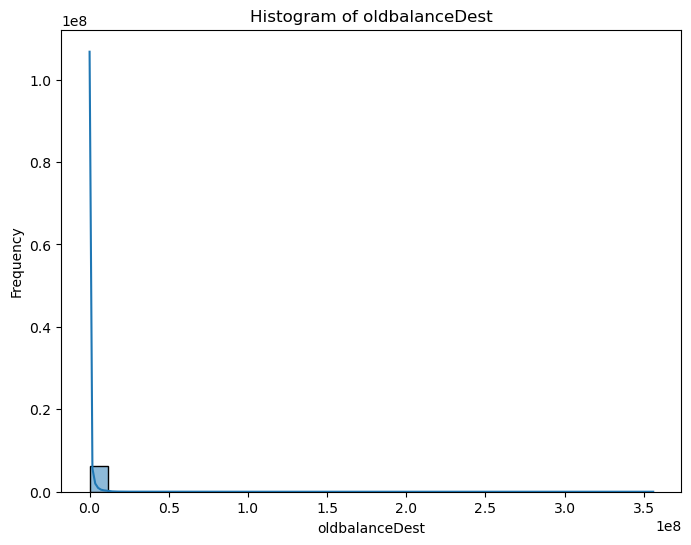

In [4]:
# Select numerical features for visualization
numerical_features = ['amount', 'oldbalanceOrg', 'oldbalanceDest']

# Plot histograms for numerical features
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=fraudie, x=feature, bins=30, kde=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

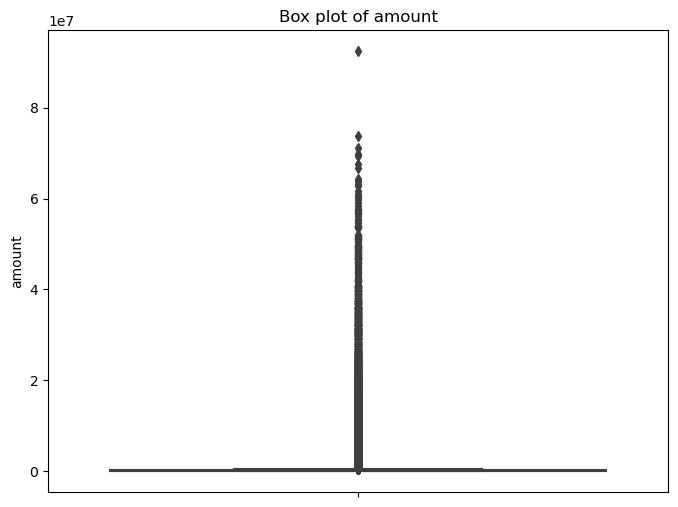

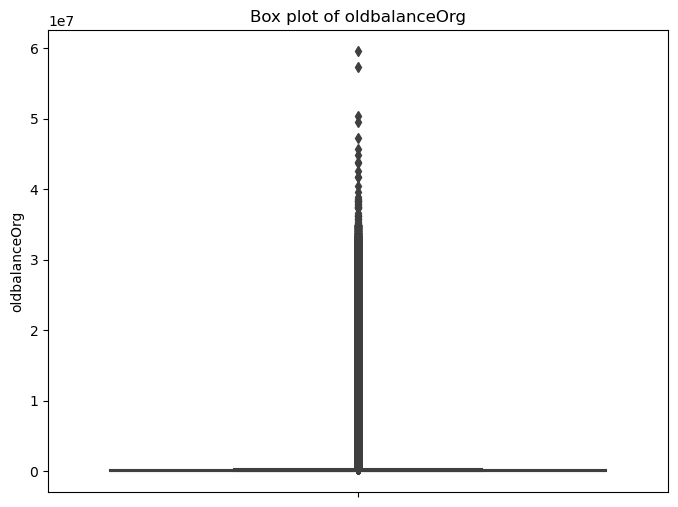

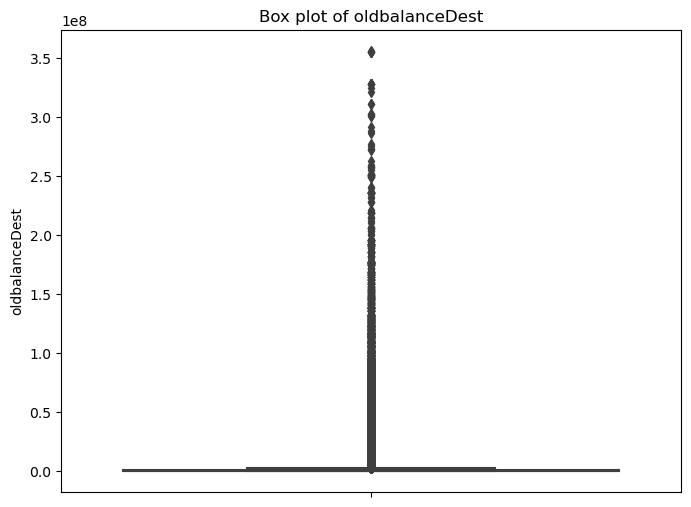

In [5]:
# Plot box plots for numerical features
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=fraudie, y=feature)
    plt.title(f'Box plot of {feature}')
    plt.ylabel(feature)
    plt.show()


## Relationship Between Variables + isFraud

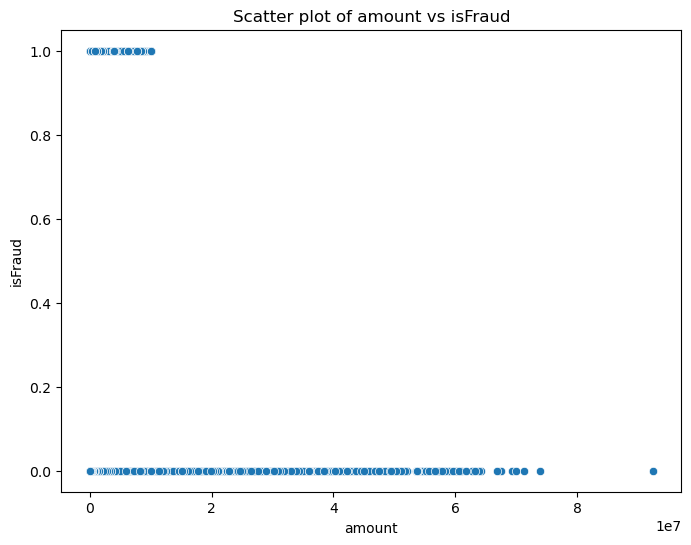

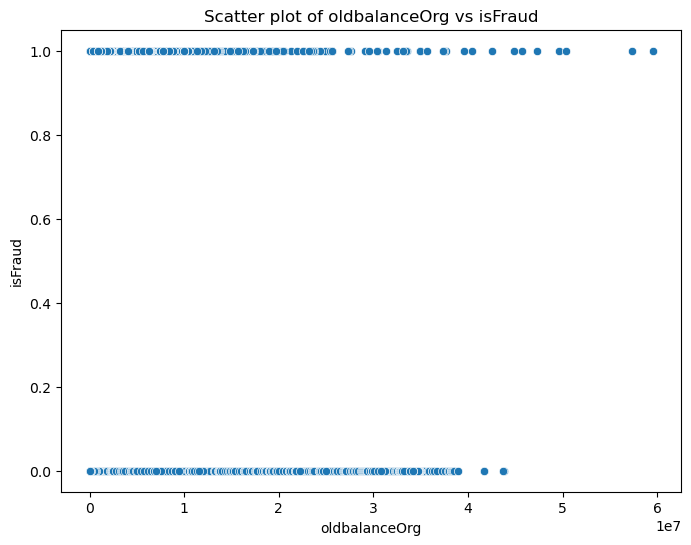

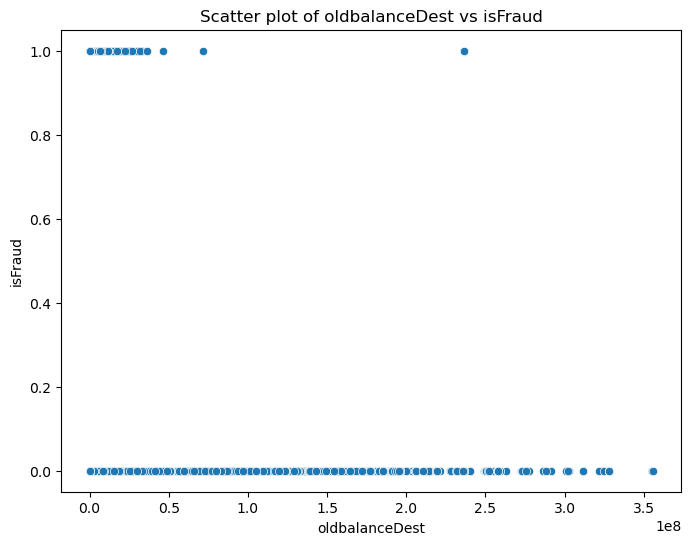

In [6]:
# Plot scatter plots for numerical features against 'isFraud'
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=fraudie, x=feature, y='isFraud')
    plt.title(f'Scatter plot of {feature} vs isFraud')
    plt.xlabel(feature)
    plt.ylabel('isFraud')
    plt.show()


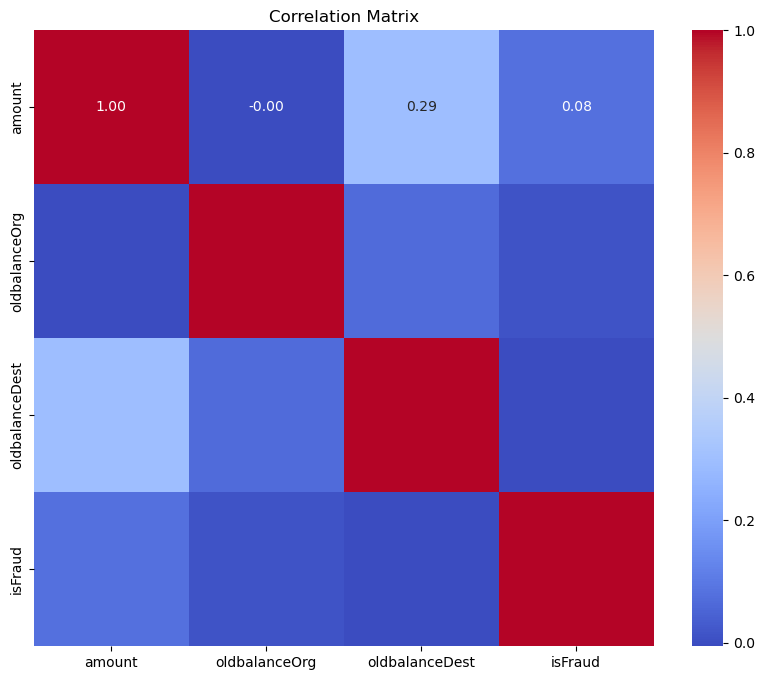

In [7]:
# Calculate correlation matrix
correlation_matrix = fraudie[numerical_features + ['isFraud']].corr()

# Plot correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [71]:


# Set random seed for reproducibility
rng = np.random.RandomState(0)

# Sample a smaller subset of the data
sample_size = 100000
fraudie_sampled = fraudie.sample(n=sample_size, random_state=rng)

# Create the 'randooutput' subfolder if it doesn't exist
os.makedirs('randooutput', exist_ok=True)
# Save the fraudie_sampled DataFrame to a CSV file in the 'randooutput' subfolder
fraudie_sampled.to_csv('randooutput/fraudie_sampled.csv', index=False)

# Split off X and y from the sampled dataset
y_sampled = fraudie_sampled['isFraud']
X_sampled = fraudie_sampled.drop('isFraud', axis=1)

# Split the sampled data into training and testing sets
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=rng)

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = ['type', 'nameOrig', 'nameDest']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, X_sampled.select_dtypes(include=['int64', 'float64']).columns),
    ('cat', categorical_transformer, categorical_features)
])

# Model selection pipeline with Random Forest
model = RandomForestClassifier(random_state=0)
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', model)
])

# Parameter grid for Random Forest
param_dist = {
    'model__n_estimators': [100, 200, 300],  # Number of trees in the forest
    'model__max_depth': [None, 10, 20],  # Maximum depth of the trees
    'model__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'model__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
}

# Use parallel processing in RandomizedSearchCV if possible
random_search = RandomizedSearchCV(pipeline, param_dist, n_iter=5, cv=3, scoring='accuracy', n_jobs=-1)
random_search.fit(X_train_sampled, y_train_sampled)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)




python(30217) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(30218) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(30219) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(30220) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(30221) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(30222) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(30223) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(30224) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Best parameters: {'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_depth': None}
Best score: 0.9989625003121797


In [73]:

# Predict on the test set
y_pred = random_search.predict(X_test_sampled)

# Compute evaluation metrics
accuracy = accuracy_score(y_test_sampled, y_pred)
precision = precision_score(y_test_sampled, y_pred)
recall = recall_score(y_test_sampled, y_pred)
f1 = f1_score(y_test_sampled, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.9994
Precision: 1.0000
Recall: 0.5000
F1-score: 0.6667


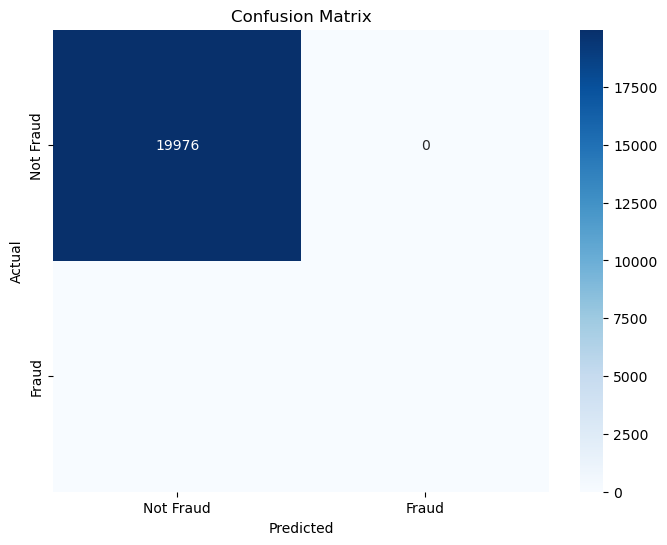

In [76]:

cm = confusion_matrix(y_test_sampled, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



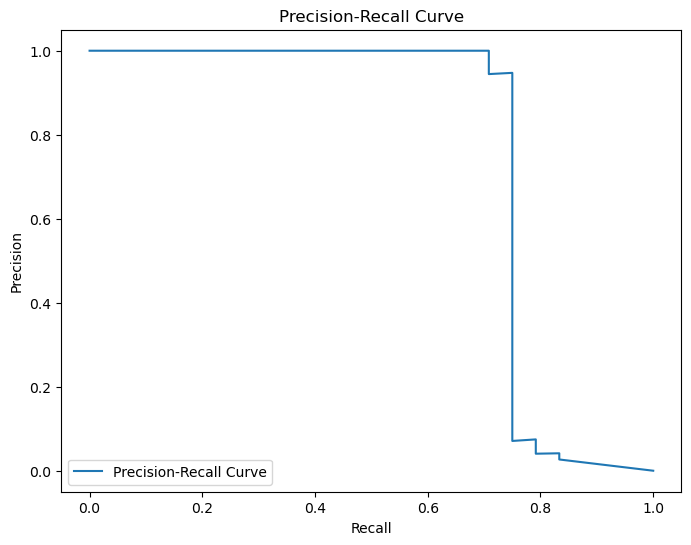

In [84]:
# Obtain predicted probabilities
y_pred_proba = random_search.best_estimator_.predict_proba(X_test_sampled)

# Keep probabilities for the positive class (fraud) only
y_pred_proba = y_pred_proba[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test_sampled, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()



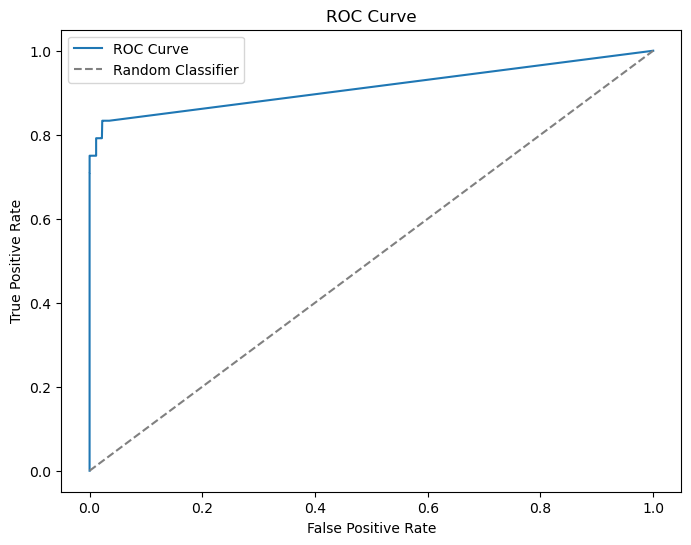

In [86]:
# Obtain predicted probabilities
y_pred_proba = random_search.best_estimator_.predict_proba(X_test_sampled)

# Keep probabilities for the positive class (fraud) only
y_pred_proba = y_pred_proba[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_sampled, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show() #testtttt

